In [1]:
import torch
from model_protein_moe import trans_basic_block, trans_basic_block_Config
from utils_search import *
from transformers import T5EncoderModel, T5Tokenizer
import re
import gc
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import defaultdict
import faiss


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
#Protein-Vec MOE model checkpoint and config
vec_model_cpnt = 'protein_vec_models/protein_vec.ckpt'
vec_model_config = 'protein_vec_models/protein_vec_params.json'

In [29]:
#Load the ProtTrans model and ProtTrans tokenizer
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
gc.collect()

model = model.to(device)
model = model.eval()

In [4]:
#Load the model
vec_model_config = trans_basic_block_Config.from_json(vec_model_config)
model_deep = trans_basic_block.load_from_checkpoint(vec_model_cpnt, config=vec_model_config)
model_deep = model_deep.to(device)
model_deep = model_deep.eval()

Lightning automatically upgraded your loaded checkpoint from v1.9.4 to v2.1.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint protein_vec_models/protein_vec.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.8.0rc0 to v2.1.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint protein_vec_models/tm_vec_swiss_model_large.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.9.4 to v2.1.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint protein_vec_models/aspect_vec_pfam.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.9.4 to v2.1.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint protein_vec_models/aspect_vec_gene3d.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.9.4 to

In [8]:
# Load in uniprot meta data
meta_data_new = pd.read_csv('data/uniprotkb_AND_reviewed_true_2023_07_03.tsv', sep='\t')
meta_data_new

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Gene Ontology (biological process),Gene Ontology (cellular component),Gene Ontology (molecular function),Gene Ontology (GO),EC number,Sequence,Date of creation,Gene3D,Pfam
0,A0A009IHW8,reviewed,ABTIR_ACIB9,2' cyclic ADP-D-ribose synthase AbTIR (2'cADPR...,J512_3302,Acinetobacter baumannii (strain 1295743),269,NAD catabolic process [GO:0019677]; signal tra...,NaN,NAD(P)+ nucleosidase activity [GO:0050135]; NA...,NAD(P)+ nucleosidase activity [GO:0050135]; NA...,3.2.2.-; 3.2.2.6,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,2020-02-26,3.40.50.10140;,PF13676;
1,A0A023I7E1,reviewed,ENG1_RHIMI,"Glucan endo-1,3-beta-D-glucosidase 1 (Endo-1,3...",ENG1 LAM81A,Rhizomucor miehei,796,cell wall organization [GO:0071555]; polysacch...,extracellular region [GO:0005576],"glucan endo-1,3-beta-D-glucosidase activity [G...",extracellular region [GO:0005576]; glucan endo...,3.2.1.39,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,2022-12-14,1.10.287.1170;1.20.5.420;,PF17652;PF03639;
2,A0A024B7W1,reviewed,POLG_ZIKVF,Genome polyprotein [Cleaved into: Capsid prote...,NaN,Zika virus (isolate ZIKV/Human/French Polynesi...,3423,clathrin-dependent endocytosis of virus by hos...,centrosome [GO:0005813]; extracellular region ...,"4 iron, 4 sulfur cluster binding [GO:0051539];...",centrosome [GO:0005813]; extracellular region ...,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,2018-01-31,1.10.10.930;1.10.260.90;1.20.1280.260;2.40.10....,PF01003;PF07652;PF02832;PF00869;PF01004;PF0094...
3,A0A024SC78,reviewed,CUTI1_HYPJR,Cutinase (EC 3.1.1.74),M419DRAFT_76732,Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,248,NaN,extracellular region [GO:0005576],cutinase activity [GO:0050525],extracellular region [GO:0005576]; cutinase ac...,3.1.1.74,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,2022-05-25,3.40.50.1820;,PF01083;
4,A0A024SH76,reviewed,GUX2_HYPJR,"Exoglucanase 2 (EC 3.2.1.91) (1,4-beta-cellobi...",cbh2 M419DRAFT_122470,Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,471,cellulose catabolic process [GO:0030245],extracellular region [GO:0005576],"cellulose 1,4-beta-cellobiosidase activity [GO...",extracellular region [GO:0005576]; cellulose 1...,3.2.1.91,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,2017-08-30,3.20.20.40;,PF00734;PF01341;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569788,W6JGV7,reviewed,REP_CPBDV,Replication-associated protein (Rep) (Viral pr...,NaN,Chaetoceros protobacilladnavirus 2 (Chaetocero...,484,DNA replication [GO:0006260]; viral DNA genome...,host cell nucleus [GO:0042025],NaN,host cell nucleus [GO:0042025]; DNA replicatio...,NaN,MSAPLSIEQDDLLTDDLKSWLSDIDFSNDNEEAIEMEPSDIEMSSP...,2018-11-07,3.40.1310.20;,NaN
569789,W6JHZ8,reviewed,VP1_CPBDV,Viral protein 1 (VP1),NaN,Chaetoceros protobacilladnavirus 2 (Chaetocero...,210,NaN,NaN,NaN,NaN,NaN,MNVKGASDKAQLAMQAEWEEVLAPEGALAVEEASSVLKISDDERRS...,2018-11-07,NaN,NaN
569790,W6JQK2,reviewed,YBW7_SCHPO,Uncharacterized protein SPBC651.07,SPBC651.07,Schizosaccharomyces pombe (strain 972 / ATCC 2...,268,NaN,NaN,NaN,NaN,NaN,MIVIEPTILYEAAALYTRYTANGGDSNDVVALLVGPIVQTLSIPSS...,2015-10-14,NaN,NaN
569791,X6R8D5,reviewed,GUCNB_HUMAN,Putative uncharacterized protein GUCA1ANB (GUC...,GUCA1ANB,Homo sapiens (Human),127,NaN,NaN,NaN,NaN,NaN,MGRKEHESPSQPHMCGWEDSQKPSVPSHGPKTPSCKGVKAPHSSRP...,2020-12-02,NaN,NaN


In [9]:
#Now filter for the proteins that were newly discovered
new_proteins = meta_data_new[meta_data_new['Date of creation'] > '2022-05-25'].reset_index(drop=True)

In [10]:
print('Number of new proteins deposited after 2022-05-25')
print(len(new_proteins))

# filter those proteins that are greater than 2000 amino acid residues long
new_proteins['length'] = new_proteins['Sequence'].str.len()
new_proteins = new_proteins[new_proteins['length'] <= 2000]
print('Filtered proteins longer than 2000 amino acids')
print(len(new_proteins))

Number of new proteins deposited after 2022-05-25
2350
Filtered proteins longer than 2000 amino acids
2295


In [15]:
# This is a forward pass of the Protein-Vec model
# Every aspect is turned on (therefore no masks)
sampled_keys = np.array(['TM', 'PFAM', 'GENE3D', 'ENZYME', 'MFO', 'BPO', 'CCO']) # this colum determine witch to chose
all_cols = np.array(['TM', 'PFAM', 'GENE3D', 'ENZYME', 'MFO', 'BPO', 'CCO'])
masks = [all_cols[k] in sampled_keys for k in range(len(all_cols))]
masks = torch.logical_not(torch.tensor(masks, dtype=torch.bool))[None,:]

#Pull out sequences for the new proteins
flat_seqs = new_proteins['Sequence'].values

#Loop through the sequences and embed them using protein-vec
i = 0
embed_all_sequences = []
while i < len(flat_seqs): 
    protrans_sequence = featurize_prottrans(flat_seqs[i:i+1], model, tokenizer, device) #firt make embading using ProTrans pretrained model
    embedded_sequence = embed_vec(protrans_sequence, model_deep, masks, device) #than use protrens embedings to get embedings from protein-vec model
    embed_all_sequences.append(embedded_sequence)
    i = i + 1
    if i % 50 == 0:
        print(i)    


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250


In [16]:
#Combine the embedding vectors into an array
query_embeddings = np.concatenate(embed_all_sequences)

Now that we have embeddings for the newly discovered proteins, we can visualize them after performing TSNE, and we can transfer annotations to them as well

In [17]:
#Perform TSNE on the embedding vectors
all_X_embedded = TSNE(n_components=2, perplexity=10, learning_rate='auto', init='random').fit_transform(query_embeddings)
all_X_embedded_df = pd.DataFrame(all_X_embedded)
all_X_embedded_df.columns = ["Dim1", "Dim2"]
all_X_embedded_df['Pfam'] = new_proteins['Pfam'].values[:len(all_X_embedded_df)]
all_X_embedded_df['EC'] = new_proteins['EC number'].values[:len(all_X_embedded_df)]

In [21]:
all_X_embedded_df

,Dim1,Dim2,Pfam,EC
0,-32.433159,-28.434998,PF17652;PF03639;,3.2.1.39
1,46.395782,55.229916,PF01583;PF01747;PF14306;,2.7.1.25; 2.7.7.4
2,-69.833466,-13.490281,PF01370;,1.2.1.-; 1.2.1.44
3,-54.153847,15.780197,PF08417;PF00355;,1.14.15.-
4,-20.607407,-23.562628,PF08516;PF00200;PF01562;PF01421;,3.4.24.-
...,...,...,...,...
2290,-42.883965,-15.126770,PF13483;,NaN
2291,10.762687,-6.765350,NaN,NaN
2292,10.762828,-6.765385,NaN,NaN
2293,15.781185,32.572666,PF10937;,NaN


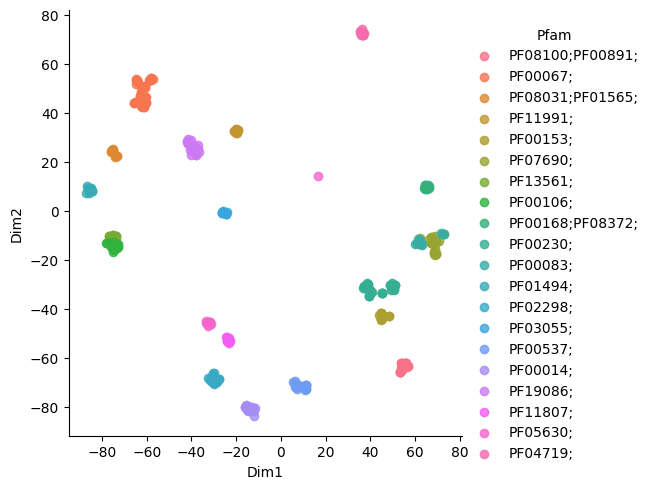

In [18]:
#For visualization purposes, filter for the top 20 PFam terms
top_ranks = list(all_X_embedded_df['Pfam'].value_counts()[0:20].index)
sns.lmplot(x="Dim1", y="Dim2", data=all_X_embedded_df[all_X_embedded_df['Pfam'].isin(top_ranks)], hue="Pfam", fit_reg=False)


In [22]:
################## Load the lookup database of all embeddings (note that we will pull out only embeddings from proteins that were trained on)
embeddings = np.load('protein_vec_embeddings/lookup_embeddings.npy')
lookup_proteins_meta = pd.read_csv('protein_vec_embeddings/lookup_embeddings_meta_data.tsv', sep="\t")


In [23]:
print("Maximum date of lookup database protein")
np.max(lookup_proteins_meta['Date of creation'])

Maximum date of lookup database protein


'2022-05-25'

We can run search and the nearest neighbor pipeline for any of our available aspects
 - 'Gene Ontology (biological process)'
 - 'Gene Ontology (molecular function)' 
 - 'Gene Ontology (cellular component)' 
 - 'Gene3D' 
 - 'Pfam' 
 - 'EC number'

In [24]:
#Switch this for whichever aspect you want to perform search for
############### User parameter
column = 'Pfam'

In [25]:
# Filter for lookup proteins with annotations for the relavant aspect (don't want to transfer null annotations)
col_lookup = lookup_proteins_meta[~lookup_proteins_meta[column].isnull()]
col_lookup_embeddings = embeddings[col_lookup.index]
col_meta_data = col_lookup[column].values

# load database
lookup_database = load_database(col_lookup_embeddings)

# Query for the 1st nearest neighbor
k = 1
D, I = query(lookup_database, query_embeddings, k)

#Get metadata for the 1st nearest neighbor
near_ids = []
for i in range(I.shape[0]):
    meta = col_meta_data[I[i]]
    near_ids.append(list(meta))       

near_ids = np.array(near_ids)

In [26]:
print("Annotations for the nearest neighbors (with aspect annotations) of newly discovered proteins")
print(near_ids)

Annotations for the nearest neighbors (with aspect annotations) of newly discovered proteins
[['PF10645;PF17652;PF03639;']
 ['PF01583;PF01747;PF14306;']
 ['PF01370;']
 ...
 ['PF04517;']
 ['PF10484;']
 ['PF07380;']]


In [27]:
near_ids

array([['PF10645;PF17652;PF03639;'],
       ['PF01583;PF01747;PF14306;'],
       ['PF01370;'],
       ...,
       ['PF04517;'],
       ['PF10484;'],
       ['PF07380;']], dtype='<U56')